In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
# calib_maglim = [3974, 6699, 9962, 11139, 12460, 13163, 19871, 
#                 21102, 22277, 26761, 28378, 29128, 38148, 41020, 
#                 41093, 44982, 45084, 46127, 49448, 50073, 53641, 67908, 72228]
# I_maglim = [38803, 39181, 39431, 39619, 40005, 40107, 40147, 40588,
#             40604, 41567, 41829, 42768, 5807403, 5057729, 4002181, 4321374, 37814]


########### Updated list using the color-LogWimx correaltion
calib_maglim = [3974, 6699, 19871, 22277, 28378, 38148, 41020, 41093, 46127, 49448, 53641]
calib_maglim += [6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 44982, 45084, 46127, 67908, 72228]

I_maglim = [38803,   39181,   39431,   39619,   40005,   40107,   40588,   40604,
   41567,   41829,   42768, 5807403, 5057729,   37814]
I_maglim += [38803, 39181, 39431, 40005, 40107, 40147, 41567, 42768]

In [3]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

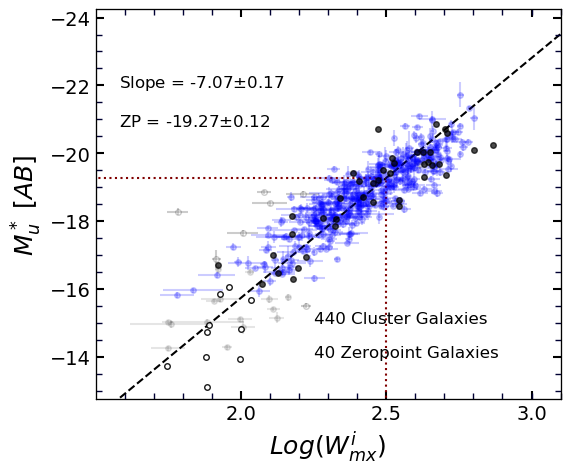

In [4]:
band = 'u'

fig, ax, Clusters, S_ZP, zp_calibs = makeTF(table, pgcFaint=I_maglim, calib_maglim=calib_maglim, 
                                 band=band, makePlot=True, 
                                            addSouth=False,
                                            getZPcalib=True)

In [5]:
slope = S_ZP[0]
slope_e = S_ZP[1]
zp    = S_ZP[2]
zp_e    = S_ZP[3]

print S_ZP

Clusters_orig = allCluster(table, band=band, pgcFaint=I_maglim)

[-7.073754103187255 0.16632116502095576 -19.27115245940447
 array([0.12402174])]


In [6]:
d_lst = []
keys = []
for i, key in enumerate(Clusters):
        myCluster = Clusters[key]
        print key, myCluster['slope'], myCluster['zp'], Clusters_orig[key]['zp']-zp, Clusters_orig[key]['name']
        
        d_modulus = Clusters_orig[key]['zp']-zp
        d_lst.append(d_modulus)
        keys.append(key)

print 

indx  = np.argsort(d_lst)

for i in indx:
    key = keys[i]
    print key, '%.1f'%d_lst[i], Clusters_orig[key]['name']

NEST_200092 -7.073754103187255 14.060951954880979 33.16263221481579 Pegasus
NEST_200037 -7.073754103187255 15.391120607978454 34.79841828679394 NGC70
NEST_200005 -7.073754103187255 14.734900275730597 34.03052342830097 NGC410
NEST_200006 -7.073754103187255 14.719421799606252 33.98724778067019 NGC507
NEST_200012 -7.073754103187255 15.366291308193265 34.62578821523297 Abell 400
NEST_200003 -7.073754103187255 14.361068032150348 33.952048300285846 Abell 262
NEST_100001 -7.073754103187255 15.327578233129705 34.60110481796844 Coma
NEST_100002 -7.073754103187255 11.646039474520206 30.975612233524092 Virgo
NEST_100005 -7.073754103187255 15.311919761184225 34.560625891825566 Abell 1367
NEST_200045 -7.073754103187255 15.369281068171073 34.67320993725623 NGC80
NEST_100007 -7.073754103187255 16.50505242306212 35.762622637229796 Abell 2151 (Hercules)
NEST_200016 -7.073754103187255 16.103850743567023 35.391510003144646 Abell 2634/66
NEST_100008 -7.073754103187255 12.105019363696302 31.356210903045877

In [7]:
def rmsMaker(logWimx, mag, logWimx_e, slope, zp):
    
    mag_fit = slope*(logWimx-2.5)+zp
    rms = np.sqrt(np.mean((mag-mag_fit)**2))
    
    logWimx_f = (mag-zp)/slope+2.5
    RMS = np.abs(slope*(np.sqrt(np.sum((logWimx-logWimx_f)**2/logWimx_e**2)/np.sum(1./logWimx_e**2))))
    
    return rms, RMS
    

Virgo (24) -6.55 0.67 11.70 0.13 11.65 0.12 0.69


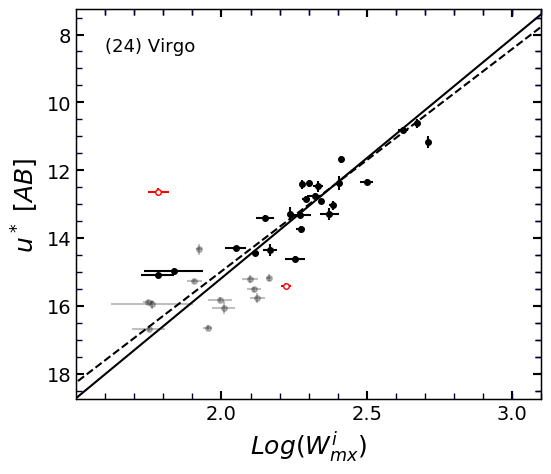

In [8]:
##########################################
def plotSingleCluster(key, xLim = (1.5,3.1), yLim = (18.75,7.25)):
#         key = 'NEST_100002'
    logWimx_, mag_, logWimx_e_, mag_e_ = plotCluster(ax, Clusters, nest=key, plotErrors=True, alpha=1., 
                        markersize=0, pgcFaint=I_maglim, plotWeird=True, color='k', 
                        alphaFaint=0.25, weirdColor='r', alphaWeird=1.)
    
    ## solid line, universal fit
    x = np.linspace(-5,5,50)
    y = slope*(x-2.5)+Clusters[key]['zp']
    ax.plot(x,y, 'k-')  
    
    
    ## dashed line, original fit
    y = Clusters_orig[key]['slope']*(x-2.5)+Clusters_orig[key]['zp']
    ax.plot(x,y, 'k--')  
    
    
    Sorig = Clusters_orig[key]['slope']
    Sorig_e = Clusters_orig[key]['slope_e']
    ZPorig = Clusters_orig[key]['zp']
    ZPorig_e = Clusters_orig[key]['zp_e']
    Zp_univ = Clusters[key]['zp']
    Zp_univ_e = Clusters[key]['zp_e']
    rms, RMS = rmsMaker(logWimx_, mag_, logWimx_e_, slope, Zp_univ)
    print Clusters_orig[key]['name'], '(%d)'%len(logWimx_), '%.2f'%Sorig, '%.2f'%Sorig_e, '%.2f'%ZPorig, '%.2f'%ZPorig_e, '%.2f'%Zp_univ, '%.2f'%Zp_univ_e, '%.2f'%rms
    
    
    ax.set_xlim(xLim)        
    ax.set_ylim(yLim)
    ax.tick_params(which='major', length=6, width=1.5, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')
    
    ax.set_xticks(np.arange(2, 3.5, step=0.5))
    
    if True:
        y_ax = ax.twinx()
        y_ax.set_ylim(yLim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

    if True:
        x_ax = ax.twiny()
        x_ax.set_xlim(xLim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')   
        x_ax.set_xticks(np.arange(2, 3.5, step=0.5))


    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
            
    ax.text(1.6,8.5, r''+"(%d)" % len(logWimx_)+' '+Clusters[key]['name'], fontsize=13)
    
##########################################    
    
    

fig, ax = makeFig(band=band, xLim = (1.5,3.1), yLim = (18.75,7.25))
plotSingleCluster('NEST_100002')

Virgo (24) -6.55 0.67 11.70 0.13 11.65 0.12 0.69
Ursa Major (37) -7.38 0.61 12.09 0.10 12.11 0.09 0.57
Pegasus (25) -8.06 1.55 13.89 0.30 14.06 0.12 0.62
Abell 262 (7) -5.26 1.23 14.68 0.27 14.36 0.23 0.66
NGC507 (20) -6.35 0.85 14.72 0.14 14.72 0.15 0.60
NGC410 (34) -6.18 0.55 14.76 0.07 14.73 0.09 0.57
Cancer (18) -5.98 0.97 14.87 0.12 14.89 0.14 0.56
Abell 1367 (68) -7.86 0.61 15.29 0.08 15.31 0.07 0.61
Coma (79) -6.91 0.48 15.33 0.07 15.33 0.07 0.67
Abell 400 (21) -6.14 0.83 15.35 0.09 15.37 0.10 0.60
NGC80 (14) -5.51 0.75 15.40 0.08 15.37 0.11 0.51
NGC70 (11) -9.05 2.14 15.53 0.23 15.39 0.14 0.48
NGC4065 (14) -6.55 0.61 15.78 0.10 15.76 0.10 0.38
Abell 2634/66 (29) -7.27 0.94 16.12 0.12 16.10 0.08 0.58
Abell 2151 (Hercules) (39) -6.90 0.66 16.49 0.09 16.51 0.08 0.54


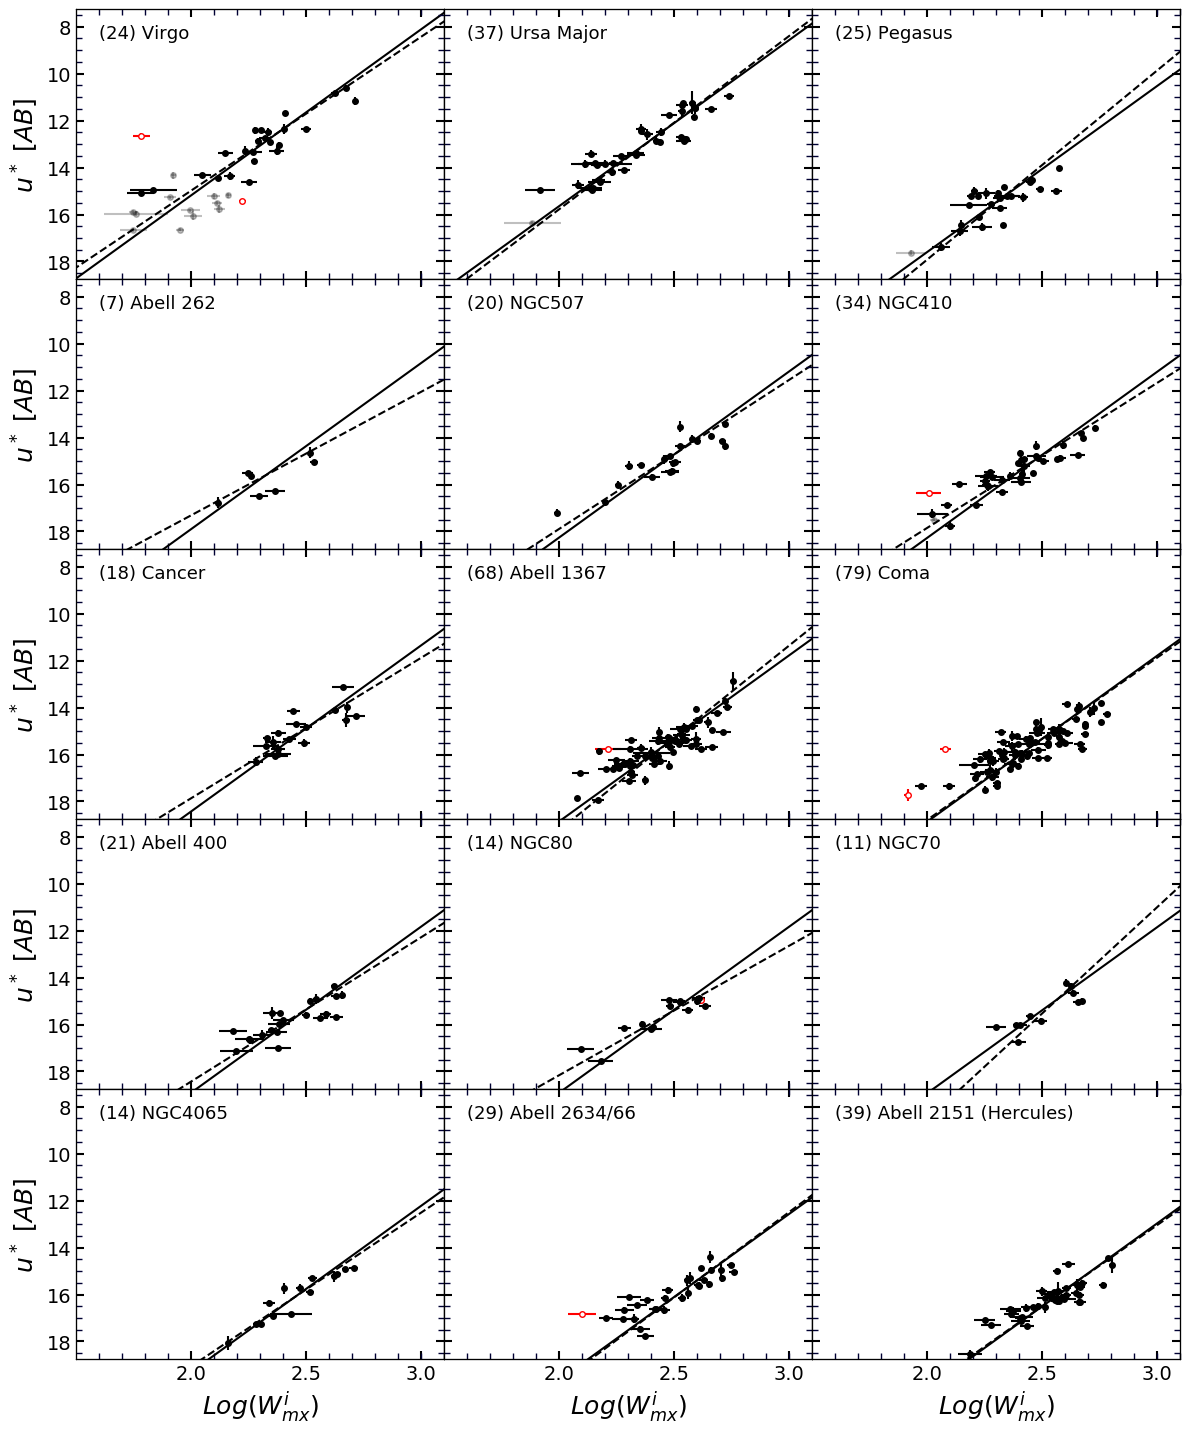

In [9]:
fig = py.figure(figsize=(12, 15), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.97, bottom=0.07, left=0.06, right=0.98)
gs = gridspec.GridSpec(5, 3); p=0


for i in indx:
    key = keys[i]
    ax = plt.subplot(gs[p])
    plotSingleCluster(key)
    
    if p%3==0: 
        ax.set_ylabel(r'$'+band+'^* \/\/ [AB]$', fontsize=18)
    else:
        plt.setp(ax.get_yticklabels(), visible=False) 
        
    if p>11: ax.set_xlabel(r'$Log( W_{mx}^i)$', fontsize=18) 
    p+=1

plt.subplots_adjust(hspace=.0, wspace=0)

In [10]:
myKeys = ['NEST_100002', 'NEST_100008', 'NEST_200092',  'NEST_200003', 'NEST_200005', 'NEST_200006', 'NEST_100030', 'NEST_200045', 'NEST_200037', 'NEST_100005', 'NEST_100001', 'NEST_200012', 'NEST_100018', 'NEST_200016', 'NEST_100007']

for key in myKeys:
    myCluster = Clusters[key]
    
    mag = myCluster['mag']
    pgc = myCluster['pgc']
    ix = []
    for i, id in enumerate(pgc):
        if not id in I_maglim:
            ix.append(i)  
    
    mags = mag[ix]
    jj = np.argsort(mags)
    
    print mags[jj][::-1][1]
    


14.96
14.94
16.72
16.47
17.24
16.76
16.05
17.04
16.11
17.85
17.36
16.99
17.25
17.47
17.32
